Reading the file

In [1]:
import pandas as pd
data = pd.read_csv('emotion_dataset_raw.csv', encoding = 'ISO-8859-1')
 
data['Emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

Sampling data (will remove later)

In [2]:
df = data.sample(n=1000)
# df = data [will keep this]
print(df.shape) 

(1000, 2)


We will summarize the data, if text data is long. 

In [3]:
import spacy
import pytextrank


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank", last=True)

def summarize_text(text):
    if len(text) >= 500:
        doc = nlp(text)
        summary = []
        for p in doc._.phrases[:5]:
            summary.append(p.text)
        return ' '.join(summary) 
    else:
        return text 

df['Text'] = df['Text'].apply(summarize_text)

c:\Users\User\anaconda3\envs\datascience_project\Lib\site-packages


We will show the label distribution 

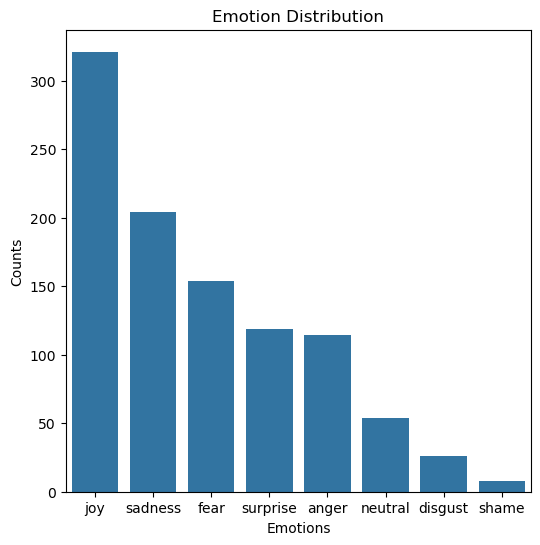

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns

x = df['Emotion'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=x.index, y=x.values)

plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Distribution')
plt.show()

Visualizing most common words for each emotion 

Most common words for fear: [('the', 100), ('I', 69), ('of', 56), ('to', 56), ('a', 54), ('and', 51), ('in', 41), ('was', 34), ('.', 30), ('that', 26)]


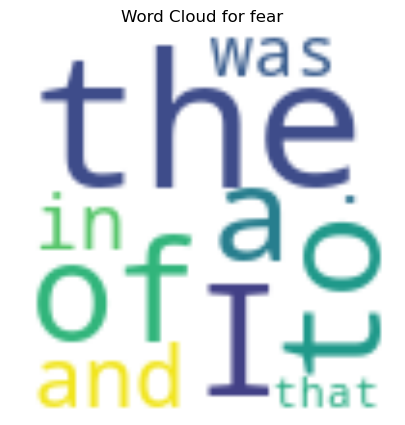

Most common words for joy: [('the', 143), ('to', 142), ('I', 110), ('a', 97), ('and', 92), ('of', 87), ('my', 77), ('.', 73), ('in', 54), ('for', 53)]


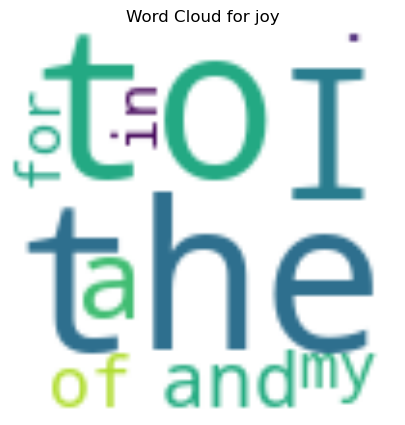

Most common words for sadness: [('I', 110), ('the', 93), ('to', 88), ('my', 64), ('a', 60), ('.', 56), ('and', 55), ('was', 38), ('of', 38), (',', 34)]


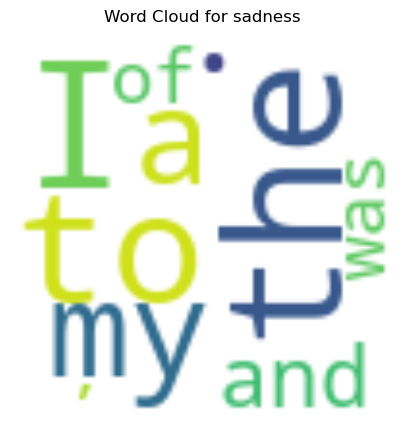

Most common words for surprise: [('to', 43), ('I', 37), ('a', 32), ('and', 27), ('the', 26), ('my', 25), ('in', 21), ('on', 18), ('is', 17), ('you', 15)]


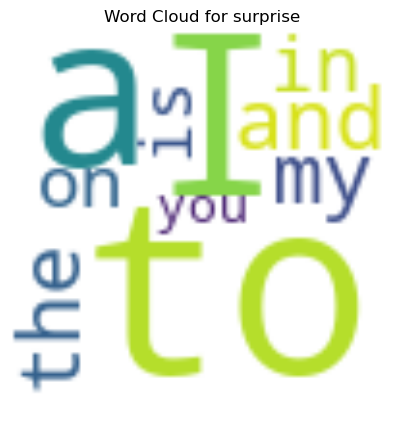

Most common words for neutral: [('.', 45), ('?', 19), ('I', 18), (',', 14), ('you', 10), ('Yes', 8), ('the', 8), ('is', 7), ('to', 5), ('Why', 5)]


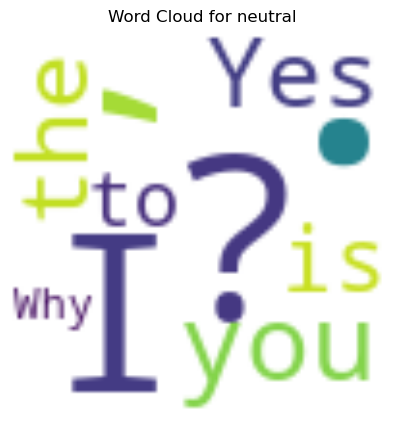

Most common words for anger: [('to', 64), ('the', 63), ('I', 58), ('a', 50), ('and', 49), ('.', 32), ('of', 31), (',', 27), ('was', 26), ('my', 26)]


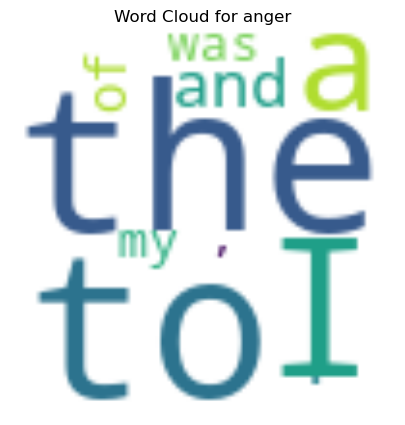

Most common words for disgust: [('the', 12), ('a', 11), ('of', 8), ('I', 8), ('is', 6), ('in', 5), ('to', 5), ('one', 5), ('and', 5), ('that', 4)]


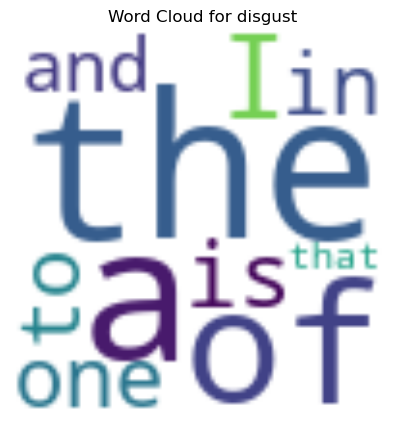

Most common words for shame: [(',', 10), ('the', 10), ('.', 8), ('of', 7), ('embarrassed', 6), ('and', 6), ('was', 4), ('he', 3), ('in', 3), ('to', 3)]


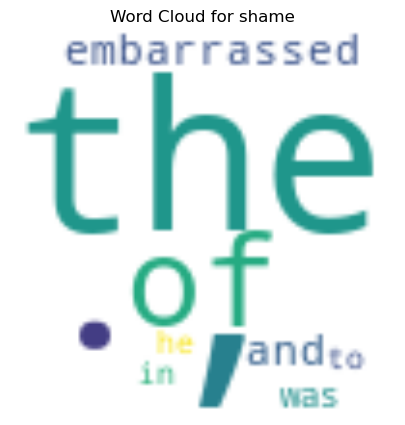

In [5]:
from wordcloud import WordCloud
from collections import Counter

def create_word_clouds(df):
    emotions = df['Emotion'].unique()
    for emotion in emotions:
        text = ' '.join(df[df['Emotion'] == emotion]['Text'])
        word_freq = Counter(text.split())
        most_common_words = word_freq.most_common(10)
        print(f"Most common words for {emotion}: {most_common_words}")

        wc = WordCloud(
            background_color="white",
            width=100,
            height=100,
            max_words=10,
            relative_scaling=0.5,
            normalize_plurals=False,
        ).generate_from_frequencies(dict(most_common_words))

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion}')
        plt.show()

create_word_clouds(df)

We will re genrate some data for emotions with lower counts.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


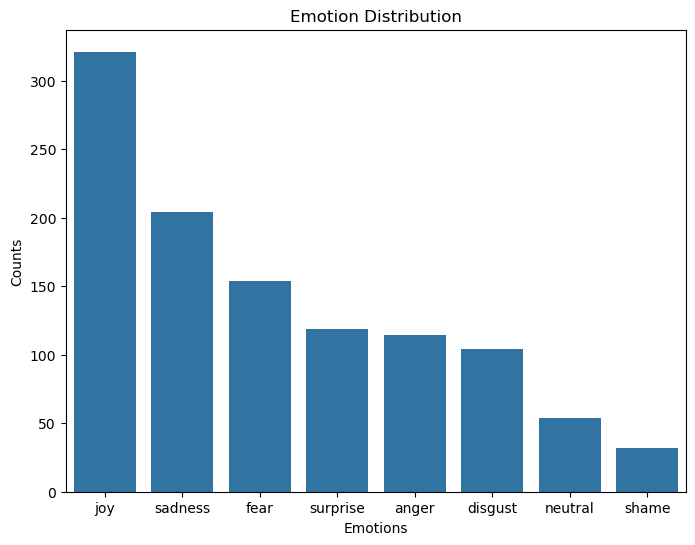

In [6]:
import pandas as pd
import nltk
import nlpaug.augmenter.word as naw
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

disgusted_texts = df[df['Emotion'] == 'disgust']['Text'].tolist()
shame_texts = df[df['Emotion'] == 'shame']['Text'].tolist()

aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

def augment_data(texts, emotion, n=2):
    augmented_texts = []
    for text in texts:
        try:
            augmented_texts.extend(aug.augment(text, n=n))
        except Exception as e:
            print(f"Error augmenting text: {text} | Error: {e}")
    return [(text, emotion) for text in augmented_texts]

augmented_disgust_texts = augment_data(disgusted_texts, 'disgust', n=3)

augmented_shame_texts = augment_data(shame_texts, 'shame', n=3)


augmented_disgust_df = pd.DataFrame(augmented_disgust_texts, columns=['Text', 'Emotion'])
augmented_shame_df = pd.DataFrame(augmented_shame_texts, columns=['Text', 'Emotion'])

df = pd.concat([df, augmented_disgust_df, augmented_shame_df], ignore_index=True)

x = df['Emotion'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=x.index, y=x.values)

plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Distribution')
plt.show()

Stop words and puncuation removal

In [7]:
import string
import re

df['Text'] = df['Text'].astype(str).str.lower()

with open("stopwords-en.txt", "r") as stopwords_file:
    stopwords_en = set(stopwords_file.read().splitlines())

punctuation = set(string.punctuation) 

updated_text = []
for text in df['Text']:
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    words = text.split()
    updated_words = [word for word in words if word not in stopwords_en]
    up_text = ' '.join(updated_words)
    cleanString = re.sub('\W+', ' ', up_text)
    updated_text.append(cleanString)

df['Text'] = updated_text

Lemmatization

In [8]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

# Ensure you have the required NLTK resources downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 


lemmatizer = WordNetLemmatizer()
updated_text_2 = []

for text in df['Text']:
    words = text.split()
    
    pos_tags = nltk.pos_tag(words)
    updated_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    updated_text = ' '.join(updated_tokens)
    updated_text_2.append(updated_text)

df['Text'] = updated_text_2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Tf-idf to convert the words into feature vector

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfVector = TfidfVectorizer()


tfidf_matrix = tfVector.fit_transform(df['Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfVector.get_feature_names_out())

df = pd.concat([df, tfidf_df], axis=1)

Converting categorical label values 

In [10]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
encoded_values = label_encoder.fit_transform(df['Emotion'])
df['encoded_Emotion'] = encoded_values

Creating training and test data

In [11]:
from sklearn.model_selection import train_test_split

X = tfidf_df
y = df['encoded_Emotion']
print(X.shape, y.shape)

SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1102, 3598) (1102,)
(881, 3598) (881,)
(221, 3598) (221,)


Finding out best classifier

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

classifiers = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}


best_model = None
best_test_accuracy = 0.0
best_model_name = ""

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"\n{name} Testing Accuracy: {test_accuracy:.4f}")


    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_model = clf
        best_model_name = name

print(f"\nBest model: {best_model_name} with Testing Accuracy: {best_test_accuracy:.4f}")


Training GaussianNB...

GaussianNB Testing Accuracy: 0.4389
Training MultinomialNB...

MultinomialNB Testing Accuracy: 0.3620
Training RandomForest...

RandomForest Testing Accuracy: 0.4751
Training SVC...

SVC Testing Accuracy: 0.4163

Best model: RandomForest with Testing Accuracy: 0.4751


In [17]:
import pickle
import joblib

model_filename = f"{best_model_name}_model.pkl"
vectorizer_filename = 'Tf_idf_vectorizer.joblib'

try:
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model '{best_model_name}' saved successfully as '{model_filename}'.")
except Exception as e:
    print(f"Error saving the model '{best_model_name}': {e}")

try:
    joblib.dump(tfVector, vectorizer_filename)
    print(f"TF-IDF vectorizer saved successfully as '{vectorizer_filename}'.")
except Exception as e:
    print(f"Error saving the TF-IDF vectorizer: {e}")


Model 'RandomForest' saved successfully as 'RandomForest_model.pkl'.
TF-IDF vectorizer saved successfully as 'Tf_idf_vectorizer.joblib'.


['vectorizer_reviews.joblib']